In [2]:
from __future__ import division
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor

import sys
sys.path.insert(0, '/Users/Naekid/Desktop/capstone-DSI-5/ebay-price-predictor/data-analysis/utilities/')
from plot_learning_curve import plot_learning_curve

pd.set_option('display.max_columns', 60)

Connect to DataBase

In [4]:
dbname='ebay'
user='nathan'
host='localhost'
TABLE_NAME = 'completed_items_v2'

engine = create_engine('postgresql://%s@%s/%s' % (user,host,dbname), echo=False)

In [4]:
df = pd.read_sql_table(TABLE_NAME, engine)

# Data Exploration

In [5]:
# yields true if there are no duplicate 'itemId'
if df['itemId'].shape[0] == len(df['itemId'].unique()):
    print 'No duplicate itemIds.'
else:
    print df['itemId'].shape[0], len(df['itemId'].unique())
    raise ValueError('Duplicate itemId in dataframe.')
    

No duplicate itemIds.


In [6]:
df.shape

(92935, 48)

In [7]:
df.head(2)

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.sellerUserName,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,location,postalCode,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,paymentMethod,isMultiVariationListing,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.gift,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription
0,30565,2017-04-05 06:17:14.195000+00:00,262804086758,True,EBAY-US,Sony Cyber-shot DSC-W830 20.1 MP HD Movie 720p...,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTA2NlgxNjAw/z/NmQAA...,http://thumbs3.ebaystatic.com/m/mS-eU_Q86jobL5...,Red,1203,99.3,hb_marketplace,True,True,Worldwide,0.0,False,1.0,Free,True,"Miami,FL,USA",33178.0,True,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-W8...,75.99,NaN,None,3.0,EndedWithSales,PayPal,False,None,1500,New other (see details),StoreInventory,False,True,False,NaN,2017-01-12 03:09:46,2017-01-14 07:03:33,This unit was a retail display. It has not be...
1,30569,2017-04-05 06:17:14.195000+00:00,302191372790,False,EBAY-US,Nikon Coolpix P500 12.1MP 36x Optical Zoom Dig...,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/oxEAA...,http://thumbs3.ebaystatic.com/m/mc6KIAyyfcvX5z...,Yellow,48,100.0,zmussani,False,True,US,0.0,False,2.0,Calculated,False,"Sugar Land,TX,USA",77479.0,False,http://www.ebay.com/itm/Nikon-Coolpix-P500-12-...,72.00,49.0,None,5.0,EndedWithSales,PayPal,False,None,3000,Used,Auction,False,False,False,NaN,2017-01-09 04:46:02,2017-01-14 04:46:02,NULL


In [8]:
df.columns.tolist()

['id',
 'timestamp',
 'itemId',
 'topRatedListing',
 'globalId',
 'title',
 'subtitle',
 'country',
 'primaryCategory.categoryId',
 'primaryCategory.categoryName',
 'secondaryCategory.categoryId',
 'secondaryCategory.categoryName',
 'pictureURLLarge',
 'galleryURL',
 'sellerInfo.feedbackRatingStar',
 'sellerInfo.feedbackScore',
 'sellerInfo.positiveFeedbackPercent',
 'sellerInfo.sellerUserName',
 'sellerInfo.topRatedSeller',
 'shippingInfo.expeditedShipping',
 'shippingInfo.shipToLocations',
 'shippingInfo.shippingServiceCost.value',
 'shippingInfo.oneDayShippingAvailable',
 'shippingInfo.handlingTime',
 'shippingInfo.shippingType',
 'autoPay',
 'location',
 'postalCode',
 'returnsAccepted',
 'viewItemURL',
 'sellingStatus.currentPrice.value',
 'startprice',
 'endPrice',
 'sellingStatus.bidCount',
 'sellingStatus.sellingState',
 'paymentMethod',
 'isMultiVariationListing',
 'condition',
 'condition.conditionId',
 'condition.conditionDisplayName',
 'listingInfo.listingType',
 'listingIn

In [9]:
df.head(2)

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.sellerUserName,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,location,postalCode,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,paymentMethod,isMultiVariationListing,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.gift,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription
0,30565,2017-04-05 06:17:14.195000+00:00,262804086758,True,EBAY-US,Sony Cyber-shot DSC-W830 20.1 MP HD Movie 720p...,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTA2NlgxNjAw/z/NmQAA...,http://thumbs3.ebaystatic.com/m/mS-eU_Q86jobL5...,Red,1203,99.3,hb_marketplace,True,True,Worldwide,0.0,False,1.0,Free,True,"Miami,FL,USA",33178.0,True,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-W8...,75.99,NaN,None,3.0,EndedWithSales,PayPal,False,None,1500,New other (see details),StoreInventory,False,True,False,NaN,2017-01-12 03:09:46,2017-01-14 07:03:33,This unit was a retail display. It has not be...
1,30569,2017-04-05 06:17:14.195000+00:00,302191372790,False,EBAY-US,Nikon Coolpix P500 12.1MP 36x Optical Zoom Dig...,Roberts Camera - Photo Industry Leader since 1...,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/oxEAA...,http://thumbs3.ebaystatic.com/m/mc6KIAyyfcvX5z...,Yellow,48,100.0,zmussani,False,True,US,0.0,False,2.0,Calculated,False,"Sugar Land,TX,USA",77479.0,False,http://www.ebay.com/itm/Nikon-Coolpix-P500-12-...,72.00,49.0,None,5.0,EndedWithSales,PayPal,False,None,3000,Used,Auction,False,False,False,NaN,2017-01-09 04:46:02,2017-01-14 04:46:02,NULL


In [10]:
df[['itemId','viewItemURL','sellingStatus.currentPrice.value','listingInfo.listingType','startprice','sellingStatus.bidCount','listingInfo.buyItNowAvailable']].ix[0:10]

,itemId,viewItemURL,sellingStatus.currentPrice.value,listingInfo.listingType,startprice,sellingStatus.bidCount,listingInfo.buyItNowAvailable
0,262804086758,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-W8...,75.99,StoreInventory,NaN,3.0,False
1,302191372790,http://www.ebay.com/itm/Nikon-Coolpix-P500-12-...,72.00,Auction,49.00,5.0,False
2,322389959274,http://www.ebay.com/itm/Canon-PowerShot-SX170-...,70.00,FixedPrice,NaN,3.0,False
3,142239979842,http://www.ebay.com/itm/Fujifilm-XP75-FinePix-...,69.99,StoreInventory,NaN,3.0,False
4,252717626714,http://www.ebay.com/itm/Sony-Cyber-DSC-H7-8-1-...,65.99,StoreInventory,NaN,3.0,False
5,182414001252,http://www.ebay.com/itm/CANON-REBEL-XTi-Digita...,72.00,Auction,49.99,10.0,False
6,302194957225,http://www.ebay.com/itm/Polaroid-Snap-Instant-...,74.88,FixedPrice,NaN,3.0,False
7,282325036031,http://www.ebay.com/itm/Fujifilm-FinePix-S7000...,65.00,StoreInventory,NaN,29.0,False
8,142237555435,http://www.ebay.com/itm/Canon-PowerShot-ELPH-3...,69.76,Auction,64.95,3.0,False
9,371836602547,http://www.ebay.com/itm/Sony-Alpha-a100-10-2-M...,75.00,Auction,0.01,29.0,False


In [27]:
print df[df['itemId']==332172404108]['viewItemURL'].values[0]

http://www.ebay.com/itm/Canon-PowerShot-Digital-ELPH-SD1100-Digital-IXUS-80-8-0MP-Digital-Camer-/332172404108


In [55]:
np.isnan(df['startprice'].iloc[1])

True

In [162]:
# listingType of ‘Auction’, no ‘startPrice’, BuyItNowAvailable=‘f’, and bidCount=1
mask = (df['sellingStatus.sellingState']=='EndedWithSales')\
            & (np.isnan(df['sellingStatus.bidCount']))
#             & (df['listingInfo.listingType']=='AuctionWithBIN')
#             & (np.isnan(df['startprice']))
#             & (df['sellingStatus.bidCount']==1.0)
#             & (np.isfinite(df['startprice'])\

df[mask].loc[:,['itemId','viewItemURL','sellingStatus.currentPrice.value','sellingStatus.sellingState','listingInfo.listingType','startprice','sellingStatus.bidCount','listingInfo.buyItNowAvailable']]

,itemId,viewItemURL,sellingStatus.currentPrice.value,sellingStatus.sellingState,listingInfo.listingType,startprice,sellingStatus.bidCount,listingInfo.buyItNowAvailable
1,162448179688,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-F7...,20.00,EndedWithSales,StoreInventory,NaN,NaN,False
2,122429789466,http://www.ebay.com/itm/Samsung-Galaxy-Camera-...,20.00,EndedWithSales,StoreInventory,NaN,NaN,False
3,222378788434,http://www.ebay.com/itm/Kodak-EasyShare-M580-1...,23.50,EndedWithSales,FixedPrice,NaN,NaN,False
4,252835915121,http://www.ebay.com/itm/Sanyo-VPC-X1200-12-0-M...,24.00,EndedWithSales,StoreInventory,NaN,NaN,False
8,132142733893,http://www.ebay.com/itm/Polaroid-M737T-7-0MP-D...,23.00,EndedWithSales,FixedPrice,NaN,NaN,False
9,262848754826,http://www.ebay.com/itm/Kodak-EasyShare-P880-5...,20.00,EndedWithSales,StoreInventory,NaN,NaN,False
11,272499024591,http://www.ebay.com/itm/Silver-Sony-Cyber-Shot...,24.00,EndedWithSales,StoreInventory,NaN,NaN,False
20,322469666570,http://www.ebay.com/itm/Kodak-EasyShare-C813-8...,21.42,EndedWithSales,StoreInventory,NaN,NaN,False
22,152496317507,http://www.ebay.com/itm/Olympus-Stylus-710-7-1...,23.99,EndedWithSales,FixedPrice,NaN,NaN,False
259,272610941974,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-H9...,20.00,EndedWithSales,StoreInventory,NaN,NaN,False


In [26]:
print df[df['itemId']==162416076668]['viewItemURL'].values[0]

http://www.ebay.com/itm/FujiFilm-FinePix-S-9150-16mp-50X-Zoom-Full-HD-Bundel-Used-/162416076668


In [20]:
df[df['itemId']==172481027840]

,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription
41,30613,2017-04-05 06:17:16.791000+00:00,172481027840,False,EBAY-US,Sony Alpha SLT-A58 20.4 MP Digital SLR Camera -,None,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NDgwWDY0MA==/z/uRQAA...,http://thumbs1.ebaystatic.com/m/mvI9fEnhMJRjgg...,Yellow,13,100.0,False,True,US,6.0,False,1,Calculated,False,False,http://www.ebay.com/itm/Sony-Alpha-SLT-A58-20-...,69.0,NaN,None,8.0,EndedWithSales,None,7000,For parts or not working,Auction,False,False,NaN,2017-01-10 03:07:32,2017-01-13 03:07:32,None


In [174]:
# 116.0 nan 7.0
mask = (df['sellingStatus.bidCount']==7.0) & (np.isnan(df['startprice'])) & (df['sellingStatus.currentPrice.value']==116.0)
print df[mask]['viewItemURL'].values[0]

http://www.ebay.com/itm/canon-eos-rebel-t3-/122337817575


In [82]:
print df[(df['listingInfo.listingType']=='Auction') & (df['sellingStatus.bidCount']==1.0)].iloc[0]['viewItemURL']

http://www.ebay.com/itm/Nikon-COOLPIX-S3100-14-0-MP-Digital-Camera-Silver-/222456355217


In [98]:
# Check to see if any listings have buyItNowAvailable == True
df[df['listingInfo.buyItNowAvailable']==True].loc[:,['itemId','viewItemURL','sellingStatus.currentPrice.value','sellingStatus.sellingState','listingInfo.listingType','startprice','sellingStatus.bidCount','listingInfo.buyItNowAvailable']]

,itemId,viewItemURL,sellingStatus.currentPrice.value,sellingStatus.sellingState,listingInfo.listingType,startprice,sellingStatus.bidCount,listingInfo.buyItNowAvailable
56,222452911011,http://www.ebay.com/itm/Nikon-COOLPIX-5700-5-0...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
63,292067974116,http://www.ebay.com/itm/Kodak-Easyshare-Digita...,22.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
71,292074420518,http://www.ebay.com/itm/HD-Video-Camera-Olympu...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
74,132141388402,http://www.ebay.com/itm/Fujifilm-FinePix-F-Ser...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
84,112348350233,http://www.ebay.com/itm/Canon-PowerShot-Digita...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
85,222454806425,http://www.ebay.com/itm/Canon-Powershot-SD4000...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
86,162448179463,http://www.ebay.com/itm/Four-4-Cameras-Sony-Ol...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
116,262910323498,http://www.ebay.com/itm/Cannon-PowerShot-G2-4-...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
117,292067175540,http://www.ebay.com/itm/purple-digital-camera-...,21.99,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True
119,232283107829,http://www.ebay.com/itm/Nikon-COOLPIX-S6200-16...,20.00,EndedWithoutSales,AuctionWithBIN,NaN,0.0,True


How many listings of each type are there?

In [7]:
df['listingInfo.listingType'].value_counts()

Auction           47486
FixedPrice        34220
StoreInventory    19087
AuctionWithBIN     3586
Name: listingInfo.listingType, dtype: int64

In [210]:
camera_category_names = ['Digital Cameras','Film Cameras','Cameras','Digital Camera parts','Other Vintage Cameras','Box Cameras','35mm Cameras']
df = df[df['primaryCategory.categoryName'].isin(camera_category_names)]

In [169]:
df.columns

Index([                                    u'id',
                                    u'timestamp',
                                       u'itemId',
                              u'topRatedListing',
                                     u'globalId',
                                        u'title',
                                     u'subtitle',
                                      u'country',
                   u'primaryCategory.categoryId',
                 u'primaryCategory.categoryName',
                 u'secondaryCategory.categoryId',
               u'secondaryCategory.categoryName',
                              u'pictureURLLarge',
                                   u'galleryURL',
                u'sellerInfo.feedbackRatingStar',
                     u'sellerInfo.feedbackScore',
           u'sellerInfo.positiveFeedbackPercent',
                    u'sellerInfo.sellerUserName',
               u'shippingInfo.expeditedShipping',
                 u'shippingInfo.shipToLocations',


# Cleaning

In [22]:
dbname='ebay'
user='nathan'
host='localhost'
TABLE_NAME = 'completed_items_v2'

conn = psycopg2.connect("dbname={} user={} host={}".format(dbname, user, host))
cur = conn.cursor()
SQL = '''
SELECT * 
FROM {} as ci
WHERE ci."listingInfo.startTime" >= '2017-01-15'
'''.format(TABLE_NAME)
df = pd.read_sql_query(sql=SQL, con=conn)

In [23]:
df['endListingType'] = ''

In [24]:
columns_to_drop = ['sellerInfo.sellerUserName','location','postalCode','paymentMethod','isMultiVariationListing','listingInfo.gift']
df = df.drop(labels=columns_to_drop, axis=1)

In [25]:
def create_end_listing_type_and_start_price(itemId, sellingState,listingType,currentPrice,startPrice,bidCount):
        
    if sellingState == 'EndedWithoutSales': # if item didnt sell, the listingType could not have changed
        endListingType = listingType 
        startPrice = currentPrice # item did not sell, so startPrice is = endPrice
        
    elif sellingState == 'EndedWithSales':
        
        if listingType == 'Auction': 
            
            bidCount = int(bidCount)
            
            if np.isnan(startPrice) and bidCount == 1:
                endListingType = 'FixedPrice' # auction was converted to BIN by user, and then sold
                startPrice = currentPrice # although technically the end price was != startPrice, it makes our lives easier to consider these listings as having been BIN the entire life of the listing
            
            elif np.isnan(startPrice) and bidCount > 1: # scrapy didn't grab anything, probably because invalid URL
                # Because if bidCount > 1, then there should be a bid history, and scrapy should have grabbed startPrice
                return ('Invalid URL', np.nan)
                
            elif np.isfinite(startPrice):
                endListingType = 'Auction'
                
                if np.isfinite(startPrice):
                    startPrice = startPrice
                        
        elif listingType == 'FixedPrice' or listingType == 'StoreInventory':
            endListingType = listingType
            startPrice = currentPrice 
    
    return pd.Series({'endListingType':endListingType,'startPrice':startPrice})
    


df[['endListingType','startPrice']] = df.apply(lambda row: create_end_listing_type_and_start_price(row['itemId'],\
                                                             row['sellingStatus.sellingState'],\
                                                             row['listingInfo.listingType'],\
                                                             row['sellingStatus.currentPrice.value'],\
                                                             row['startprice'],\
                                                             row['sellingStatus.bidCount']), \
         axis=1)

Delete listings in which scrapy couldn't access the URL, probably because the URL no longer exists

In [26]:
df = df[df['endListingType']!='Invalid URL']

Convert bid count to int, and -1 for items that can't have any  bids (FixedPrice, storeinventory)

In [27]:
def bid_count_to_int(bidCount):
    if bidCount != bidCount:
        return -1
    else:
        return int(bidCount)


df['sellingStatus.bidCount'] = df['sellingStatus.bidCount'].apply(bid_count_to_int)

In [28]:
# mask1 = (np.isfinite(df['listingInfo.buyItNowPrice.value']))
# mask2 = (df['endListingType']=='Auction')
# mask3 = (df['sellingStatus.sellingState']=='EndedWithSales')
# mask4 = (df['sellingStatus.bidCount']>1.0)
# mask = mask2 & mask3 & mask4
# df[mask].head(4)
# print df[df['itemId']==282420311215]['viewItemURL'].values[0]

Create 'sold_state' target column

In [29]:
df['sold_state'] = df['sellingStatus.sellingState'].apply(lambda x: 1 if x=='EndedWithSales' else 0)

Transform True/False into 1/0

In [30]:
true_false_col = ['topRatedListing','shippingInfo.expeditedShipping','shippingInfo.oneDayShippingAvailable',
                 'autoPay','returnsAccepted',
                  'listingInfo.bestOfferEnabled','listingInfo.buyItNowAvailable']
for col in true_false_col:
    df[col] = df[col].apply(lambda x: 0 if x==False else 1)

replace 'NULL' in df['conditiondescription'] with empty string

In [31]:
df['conditiondescription'] = df['conditiondescription'].apply(lambda x: '' if x=='NULL' else x)

Create conditionAvailable column

In [32]:
df['conditionAvailable'] = df['conditiondescription'].apply(lambda x: 1 if x!='' else 0)

Impute endPrice

In [33]:
df['endPrice'] = df['sellingStatus.currentPrice.value']

Convert startTime and endTime to timestamp

In [34]:
df['listingInfo.endTime'] = pd.to_datetime(df['listingInfo.endTime'], utc=True)
df['listingInfo.startTime'] = pd.to_datetime(df['listingInfo.startTime'], utc=True)

**Create multiple dataframes for Auctions, FixedPrice, StoreInventory**

In [35]:
# auctions_w_bin = df[df['endListingType']=='AuctionWithBIN'].reset_index() # these didn't sell 
auctions = df[df['endListingType']=='Auction'].reset_index()
# fixed_price = df[df['endListingType']=='FixedPrice'].reset_index()
# store_inventory = df[df['endListingType']=='StoreInventory'].reset_index()

In [36]:
print 'total listings:', df.shape[0]
# print 'num AuctionWithBIN listings', auctions_w_bin.shape[0]
print 'num Auction listings:', auctions.shape[0]
# print 'num FixedPrice listings:', fixed_price.shape[0]
# print 'num StoreInventory listings:', store_inventory.shape[0]

total listings: 89259
num Auction listings: 29961


Delete unecessary objects 

In [16]:
del df

Make Pickles

In [28]:
auctions.to_pickle('./pickles/auctions.p')

# EDA

Plot the distribution of endPrice for differnet types of listings.

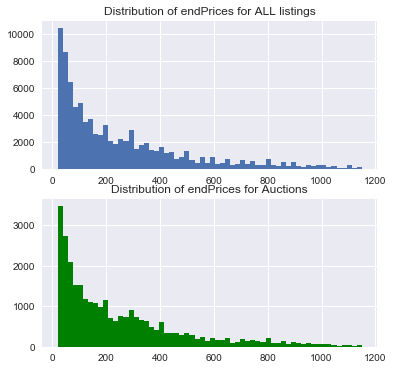

In [37]:
fix, axarr = plt.subplots(2, figsize=(6,6))
axarr[0].hist(df['endPrice'].values, bins=60);
axarr[0].set_title('Distribution of endPrices for ALL listings')
axarr[1].hist(auctions['endPrice'].values, bins=60, color='g');
axarr[1].set_title('Distribution of endPrices for Auctions')

There are very few auction listings with an endPrice of ~120 to ~180 dollars. I am not sure why this is. It could be just because when we grabbed data with the API, just didn't get a lot of auctions back that had an endPrice of around 120-180 dollars. 

you will know that issue has been fixed if the two distributions above look very similar. 

(0, 10)

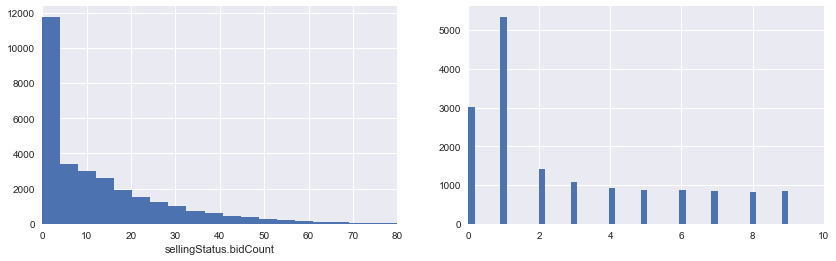

In [215]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4));
sns.distplot(a=df['sellingStatus.bidCount'], bins=50, ax=ax1, kde=False, hist_kws={'alpha':1})
ax1.set_xlim((0,80))
sns.distplot(a=df[df['sellingStatus.bidCount'] < 10]['sellingStatus.bidCount'].reset_index().drop('index',axis=1), bins=50, ax=ax2, kde=False, hist_kws={'alpha':1})
ax2.set_xlim((0,10))

Look at start times vs. sold amount? 

In [41]:
df['listingInfo.startTime.hour'] = df['listingInfo.startTime'].apply(lambda x: x.hour)
df['listingInfo.startTime.weekday'] = df['listingInfo.startTime'].apply(lambda x: x.weekday())

In [42]:
df[['id','listingInfo.startTime.hour']].groupby(by='listingInfo.startTime.hour').count()

,id
listingInfo.startTime.hour,
0,5368
1,5989
2,6358
3,5143
4,3514
5,2442
6,1770
7,1370
8,1070


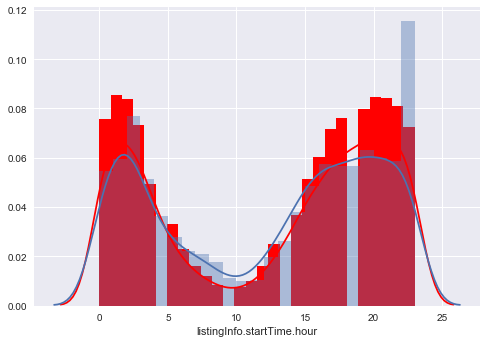

In [44]:
sns.distplot(a=df[df['sold_state']==1]['listingInfo.startTime.hour'],  kde=True, color='r', hist_kws={'alpha':1})
sns.distplot(a=df[df['sold_state']==0]['listingInfo.startTime.hour'], kde=True)

In [46]:
hour_sold = df[df['sold_state']==1][['id','listingInfo.startTime.hour']].groupby(by='listingInfo.startTime.hour').count()
hour_unsold = df[df['sold_state']==0][['id','listingInfo.startTime.hour']].groupby(by='listingInfo.startTime.hour').count()

hour = (hour_sold - hour_unsold) / df[['id','listingInfo.startTime.hour']].groupby(by='listingInfo.startTime.hour').count()

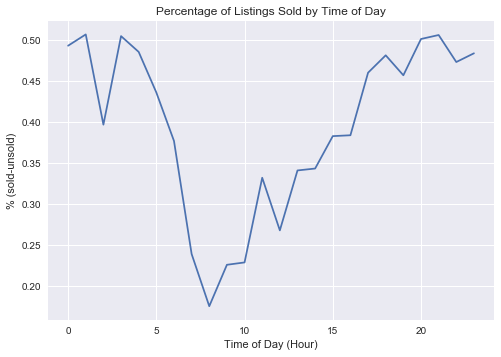

In [58]:
fig = plt.figure()
plt.plot(hour)
plt.title('Percentage of Listings Sold by Time of Day')
plt.ylabel('% (sold-unsold)')
plt.xlabel('Time of Day (Hour)')
plt.savefig('./Image/Percentage of Listings Sold by Time of Day.jpeg')

# Classifying Auctions
---

Feature selection

In [3]:
# auctions = pd.read_pickle('./pickles/auctions.p')

In [59]:
auctions.head(2)

,index,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription,endListingType,startPrice,sold_state,conditionAvailable
0,1,78584,2017-04-06 03:20:46.048000+00:00,322461255962,0,EBAY-US,Canon EOS Rebel SL1 / EOS 100D 18.0 MP Digital...,Buy Direct from Best Buy,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NTAwWDUwMA==/z/YqcAA...,http://thumbs3.ebaystatic.com/m/mv_DS7lPhi2xP4...,Blue,98,91.7,False,1,"{US,CA,GB,AU,AT,BE,FR,DE,IT,JP,ES,TW,NL,HK,MX,...",0.0,0,2.0,Calculated,0,1,http://www.ebay.com/itm/Canon-EOS-Rebel-SL1-EO...,399.0,NaN,399.0,0,EndedWithoutSales,None,1000,New,Auction,0,0,529.0,2017-03-23 18:27:59,2017-03-30 18:27:59,,Auction,399.0,0,0
1,5,78567,2017-04-06 03:20:46.048000+00:00,332163381834,0,EBAY-US,Sony Cyber-shot DSC-RX100 20.2MP Digital Camer...,Refurbished with 90 Day Nikon Warranty,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/4AsAA...,http://thumbs3.ebaystatic.com/m/myycjRB33Dwncv...,Yellow,45,100.0,False,1,"{US,CA,GB,AU,AT,BE,FR,DE,IT,JP,ES,TW,NL,HK,MX,...",0.0,0,3.0,Calculated,1,0,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-RX...,369.0,300.0,369.0,10,EndedWithSales,None,1000,New,Auction,0,0,NaN,2017-03-23 23:26:46,2017-03-30 23:26:46,,Auction,300.0,1,0


In [60]:
# Use the conditionDisplayName if conditiondescription is empty
auctions['conditionCombined'] = ''
auctions['conditionCombined'] = auctions.apply(lambda x: x['condition.conditionDisplayName'] if (x['conditiondescription']=='' or x['conditiondescription']==None ) else x['conditiondescription'], axis=1)

In [61]:
# Use startPrice, title (vectorized), conditionDisplayName (one-hot-encoded)
auction_condition_dummies = pd.get_dummies(data=auctions['condition.conditionDisplayName'])

start_price_series = auctions['startPrice']

titles = auctions['title']

sold = auctions['sold_state']

condition_combined = auctions['conditionCombined']

end_price = auctions['endPrice']

start_time_series = auctions['listingInfo.startTime']

end_time_series = auctions['listingInfo.endTime']

# Vectorize

#### Clean titles

In [62]:
# for title in titles[:10]:
#     print title, '\n'

In [63]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

def clean_text(doc, remove_stop_words=True, remove_digits=False, remove_punc=True, stem=False):
    
    # 1. Remove any HTML markup
    text = BeautifulSoup(doc).get_text()  
    
    # 2. Extract special negator like n't
    text = re.sub('n\'t', ' not', text)
    
    # 3. remove punctuation(except .-)
    if remove_punc:
        text = re.sub('[^a-zA-Z.\-\d]', ' ', text)
        
    if remove_digits:
        text = re.sub('[.\d]', ' ', text)
        
    # 4. Convert to lower case 
    text = text.lower()
        
    # 5. Remove stop words
    if remove_stop_words:
        stops = set(stopwords.words("english"))
        text = [w for w in text.split(' ') if not w in stops]
        text = ' '.join(text)
                
    # 6. apply Porter Stemming
    # probably don't need this
    if stem:
        stemmer = PorterStemmer()
        stemmer = LancasterStemmer()
        text = [stemmer.stem(w) for w in text.split(' ')]
        text = ' '.join(text)
        
    # 7. Remove extra white space
    text = re.sub(' +',' ', text)
        
    return text

In [64]:
clean_titles = []
for i,title in enumerate(titles.values):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_titles.append(clean_text(title))

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents


In [65]:
# Test for cleaning conditions
# for i in range(10):
#     print condition_combined[i]
#     print clean_text(condition_combined[i], remove_digits=True, remove_punc=True)

In [66]:
clean_conditions = []
for i,cond in enumerate(condition_combined):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_conditions.append(clean_text(cond))

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents


### Feature Engineer - Vectorize

Strategy: I want to use CountVectorizer, because I'm really searching for the presence of certain words/word combinations. I don't care so much about weighing up unique words because I expect a lot of the listings to be similar. For instance, I don't want to weigh the phrase "24.2 MP" down just because it appears in many of the listings, because it's an important phrase even if it is not that unique to the particular listing.

In [67]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),
                             min_df=5,
                             analyzer='word',
                             stop_words=None,
                             max_features=10000,
                            )

titles_matrix = vectorizer.fit_transform(clean_titles)

import operator
print sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
titles_df = pd.DataFrame(titles_matrix.todense(), columns=vectorizer.vocabulary_.keys())

[(u'zuiko digital', 6949), (u'zuiko 14', 6948), (u'zuiko', 6947), (u'zs8 14', 6946), (u'zs8', 6945)]


In [68]:
vectorizer = CountVectorizer(ngram_range = (1,2),
                             min_df=30,
                             analyzer='word',
                             stop_words=None,
                             max_features=5000,
                            )

conditions_matrix = vectorizer.fit_transform(clean_conditions)

import operator
# sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=False) # print 
print 'most common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
print 'least common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=False)[:5]
conditions_df = pd.DataFrame(conditions_matrix.todense(), columns=vectorizer.vocabulary_.keys())

most common condition grams: [(u'zoom', 772), (u'years', 771), (u'year', 770), (u'wrong', 769), (u'wrist strap', 768)]
least common condition grams: [(u'000', 0), (u'10', 1), (u'100', 2), (u'12', 3), (u'14', 4)]


Clean up unused variables

In [69]:
del clean_titles
del clean_conditions
del conditions_matrix
del titles_matrix

## Create Processed DataFrame

**Create processed feature dataframe**

In [70]:
data_frames_to_keep = [titles_df, conditions_df, auction_condition_dummies, start_price_series, sold]
df_classification = pd.concat(data_frames_to_keep, axis=1)

**Split data for modeling. **

In [71]:
X_class = df_classification.ix[:, :-1].values
y_class = df_classification.ix[:, -1].values

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, random_state=42, test_size=0.2)

## Model - Random Forest

In [72]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rfc.fit(X_train_class, y_train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [73]:
print 'top 5 features:'
sorted(zip(df_classification.columns.tolist()[:-1], rfc.feature_importances_), key=lambda x: x[1], reverse=True)[:5]

top 5 features:


[('startPrice', 0.11064606298502251),
 (u'255', 0.015012932212712431),
 (u'p5000', 0.010223466110666933),
 (u'ds126251', 0.0065880819509395398),
 (u'50mm prime', 0.0059883829551164143)]

## Score Model 

In [74]:
def calculate_baseline_classification(y):
    y_true = y
    y_naive = np.ones(y.shape[0])
    print accuracy_score(y_true, y_naive)

In [75]:
from sklearn.metrics import accuracy_score
# calculate baseline
y_true = y_train_class
y_pred = np.ones(y_true.shape[0])
print accuracy_score(y_true, y_pred)
print np.sum(y_train_class==1) / float(np.sum(y_train_class==1) + np.sum(y_train_class==0))

0.853763351135
0.853763351135


In [76]:
scores = cross_val_score(estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1), X=X_class, y=y_class, scoring='accuracy',cv=3, n_jobs=-1)
print np.mean(scores)

0.838954676547


**Confusion Matrix**

In [64]:
y_true = y_test_class
y_pred = rfc.predict(X_test_class)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

print 'Precision (TP, FP): ', TP, FP, 'Prec = ', (TP)/(TP + FP)
print 'recall (TP, FN): ', TP, FN, 'Recall = ', (TP)/(TP + FN)

Precision (TP, FP):  2644 321 Prec =  0.89173693086
recall (TP, FN):  2644 90 Recall =  0.967081199707


**ROC Curve**

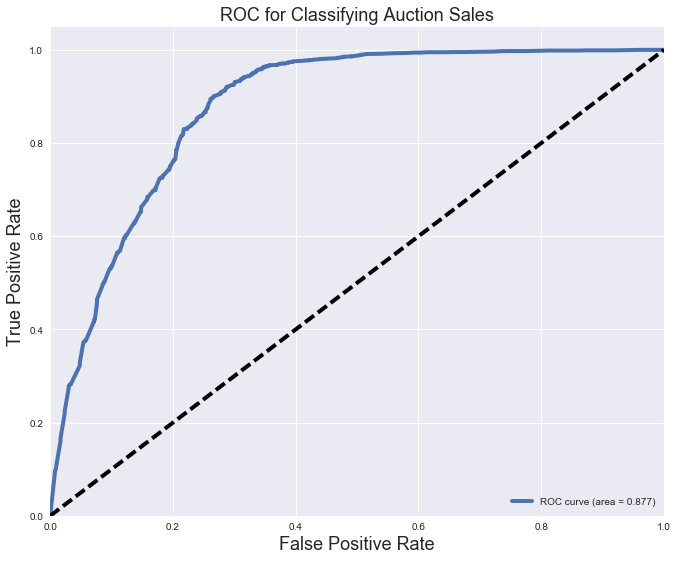

AUC: 0.877013959736


In [65]:
y_prob = rfc.predict_proba(X_test_class)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y_test_class, y_prob[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.3f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for Classifying Auction Sales', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print 'AUC:',ROC_AUC[1]

Explore what affect the startPrice has on probability of selling? We are interested in answering the question, as we increase startPrice do we decrease the probability of selling? 

<br>
We will do this calculation for itemId = 132141823402, "Sony Cyber-shot DSC-HX300 20.4MP Digital Camera"

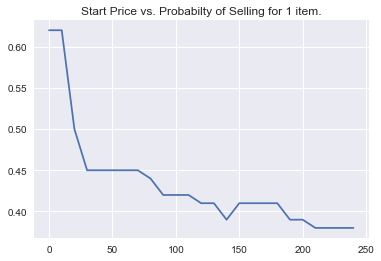

In [125]:
# Select an item index to view start price vs. probability of sold 
item_index = 0

test_item = df_classification.ix[item_index]

testStartPrice = test_item.loc['startPrice']

minStartPrice = 0
maxStartPrice = testStartPrice * 2
priceStepSize = 10

sold_probabilities = []
    
    
for price in np.arange(minStartPrice, maxStartPrice, priceStepSize):
    test_item.loc['startPrice'] = price
    test_vec = test_item.iloc[:-1].values.reshape(1,-1)
    sold_proba = rfc.predict_proba(test_vec)[0][1]
    sold_probabilities.append((price, sold_proba))
    
test_item_df = pd.DataFrame(sold_probabilities)

plt.plot(test_item_df[0], test_item_df[1])
plt.title('Start Price vs. Probabilty of Selling for 1 item.')

Test for over-fitting by using KFold()/StratifiedKFold() to calculate train error and test error, so we can compare them. 

In [329]:
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
scores = []
for i,(train_indeces, test_indeces) in enumerate(skf.split(X_class,y_class)):
    print 'training #{} model out of {}.'.format(i, num_splits)
#     print("TRAIN:", train_indeces, "TEST:", test_indeces)
    X_train, X_test = X_class[train_indeces], X_class[test_indeces]
    y_train, y_test = y_class[train_indeces], y_class[test_indeces]
    
    rfc.fit(X_train, y_train)
    y_pred_train = rfc.predict(X_train)
    y_pred_test = rfc.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    scores.append((acc_train, acc_test))    

training #0 model out of 5.
training #1 model out of 5.
training #2 model out of 5.
training #3 model out of 5.
training #4 model out of 5.


In [331]:
sorted(scores, key=lambda x: x[0], reverse=True)

[(0.99027586206896556, 0.88279095421952569),
 (0.98958764308371261, 0.88548565121412803),
 (0.98958764308371261, 0.89486754966887416),
 (0.98931034482758617, 0.8844456701599559),
 (0.98931034482758617, 0.8844456701599559)]

Looks like we are over-fitting since our training error rate is much much higher than the test. 

## Investigate errors of model

In [35]:
y_pred = rfc.predict(X)
auctions['y_pred'] = y_pred
y_true = auctions['sold'].values

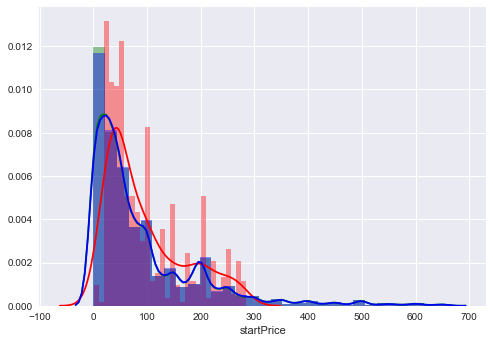

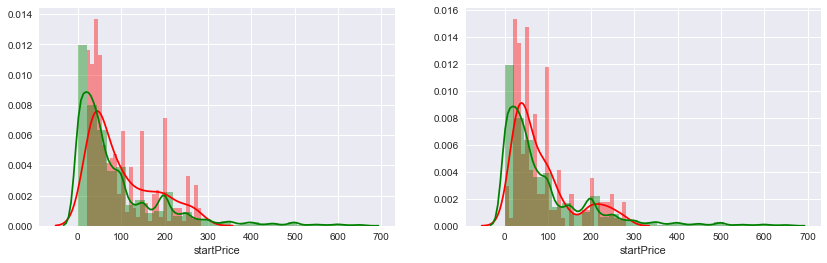

In [45]:
residuals = auctions[auctions['y_pred']!=auctions['sold']]
correct = auctions[auctions['y_pred']==auctions['sold']]
fp = auctions[(auctions['y_pred']==1) & (auctions['sold']==0)]
fn = auctions[(auctions['y_pred']==0) & (auctions['sold']==1)]

fig = plt.figure()
sns.distplot(correct['startPrice'], bins=30, color='g')
sns.distplot(residuals['startPrice'], bins=30, color='r')
sns.distplot(auctions['startPrice'], bins=30, color='b')

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
sns.distplot(fp['startPrice'], bins=30, color='r',ax=ax1)
sns.distplot(correct['startPrice'], bins=30, color='g',ax=ax1)

sns.distplot(fn['startPrice'], bins=30, color='r',ax=ax2)
sns.distplot(correct['startPrice'], bins=30, color='g',ax=ax2)


# Auction Regression - Predicting Sale Price 
---

In [77]:
auctions = pd.read_pickle('./pickles/auctions.p')

In [81]:
concurrent_similar_median_start_price_series = pd.read_pickle('./feature-engineering-concurrent-similar-median-start-price/pickles/auctions_median_start_price_series.p')
concurrent_similar_median_start_price_series.name = 'concurrent_similar_median_start_price'
concurrent_similar_median_start_price_series[concurrent_similar_median_start_price_series.isnull()] = np.median(auctions['startPrice'])

In [78]:
# Use startPrice, title (vectorized), conditionDisplayName (one-hot-encoded)
auction_condition_dummies = pd.get_dummies(data=auctions['condition.conditionDisplayName'])

start_price_series = auctions['startPrice']

titles = auctions['title']

sold = auctions['sold_state']

condition_combined = auctions['conditionCombined']

end_price = auctions['endPrice']

start_time_series = auctions['listingInfo.startTime']

end_time_series = auctions['listingInfo.endTime']

feedback_percent_series = pd.Series(auctions['sellerInfo.positiveFeedbackPercent'], name='feedback_percent')

top_rated_seller_series = pd.Series(auctions['sellerInfo.topRatedSeller'].apply(lambda x: 1 if x==True else 0), name='top_rated_seller')

expedited_shipping_series = pd.Series(auctions['shippingInfo.expeditedShipping'], name='expedited_shipping')

shipping_cost_series = pd.Series(auctions['shippingInfo.shippingServiceCost.value'], name='shipping_cost')

handling_time_series = pd.Series(auctions['shippingInfo.handlingTime'], name='handling_time')

one_day_shipping_series = pd.Series(auctions['shippingInfo.oneDayShippingAvailable'], name='one_day_shipping')

one_day_shipping_series = pd.Series(auctions['shippingInfo.oneDayShippingAvailable'], name='one_day_shipping')

returns_accepted_series = pd.Series(auctions['returnsAccepted'], name='returns_accepted')



In [79]:
clean_titles = []
for i,title in enumerate(titles.values):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_titles.append(clean_text(title))

clean_conditions = []
for i,cond in enumerate(condition_combined):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_conditions.append(clean_text(cond))
    
    
vectorizer = TfidfVectorizer(ngram_range = (1,2),
                             min_df=5,
                             analyzer='word',
                             stop_words=None,
                             max_features=10000,
                            )

titles_matrix = vectorizer.fit_transform(clean_titles)

import operator
# print sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]

titles_df = pd.DataFrame(titles_matrix.todense(), columns=vectorizer.vocabulary_.keys())

vectorizer = CountVectorizer(ngram_range = (1,2),
                             min_df=30,
                             analyzer='word',
                             stop_words=None,
                             max_features=5000,
                            )

conditions_matrix = vectorizer.fit_transform(clean_conditions)

import operator
# print 'most common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
# print 'least common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=False)[:5]

conditions_df = pd.DataFrame(conditions_matrix.todense(), columns=vectorizer.vocabulary_.keys())

del clean_titles
del clean_conditions
del conditions_matrix
del titles_matrix

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents
cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents


In [82]:
data_frames_to_keep = [titles_df,\
                       conditions_df,\
                       auction_condition_dummies,\
                       feedback_percent_series,\
                       top_rated_seller_series,\
                       expedited_shipping_series,\
                       shipping_cost_series,\
                       handling_time_series,\
                       one_day_shipping_series,\
                       returns_accepted_series,\
                       start_price_series,\
                       concurrent_similar_median_start_price_series,\
                       sold,\
                       end_price]

df_regression = pd.concat(data_frames_to_keep, axis=1)

In [ ]:
# Train the model on items that sold only
# df_regression = df_regression[df_regression['sold_state']==1]

In [88]:
# Impute missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='most_frequent', axis=0)
df_regression['shipping_cost'] = imputer.fit_transform(df_regression['shipping_cost'].values.reshape(-1,1))
df_regression['handling_time'] = imputer.fit_transform(df_regression['handling_time'].values.reshape(-1,1))

In [90]:
df_regression.isnull().sum()

z990 12                                  0
excellent cond                           0
lumix digital                            0
grip charger                             0
medium format                            0
270                                      0
275                                      0
kodak                                    0
af nikon                                 0
body read                                0
cmos smart                               0
package deal                             0
card case                                0
lens free                                0
batteries strap                          0
e6                                       0
slt a33                                  0
slt a35                                  0
zoom lense                               0
fe fe                                    0
elph 170                                 0
fujifilm pro1                            0
tz25                                     0
body workin

In [91]:
df_regression.head(5)

,z990 12,excellent cond,lumix digital,grip charger,medium format,270,275,kodak,af nikon,body read,cmos smart,package deal,card case,lens free,batteries strap,e6,slt a33,slt a35,zoom lense,fe fe,elph 170,fujifilm pro1,tz25,body working,12 megapixel,titanium,zoom mega,fuji fine,dsc f707,travel,...,scratches dents,cleaned,condition low,please read,shutter actuations,store returns,dent,operational,know,repair,warranty,ex,little use,For parts or not working,Manufacturer refurbished,New,New other (see details),Seller refurbished,Used,feedback_percent,top_rated_seller,expedited_shipping,shipping_cost,handling_time,one_day_shipping,returns_accepted,startPrice,concurrent_similar_median_start_price,sold_state,endPrice
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,91.7,0,1,0.00,2.0,0,1,399.00,92.5,0,399.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100.0,0,1,0.00,3.0,0,0,300.00,92.5,1,369.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,99.8,1,0,17.99,1.0,0,1,349.99,92.5,1,385.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100.0,0,0,0.00,2.0,0,1,0.99,92.5,1,387.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,100.0,0,1,15.00,3.0,0,0,380.00,92.5,0,380.0


**Save df_regression to pickle**

In [44]:
df_regression.to_pickle('./pickles/df_regression_tfidf_all.p')

**Split values into train/test**

In [92]:
X = df_regression.ix[:, :-1].values
y = df_regression.ix[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

** Support Vector Regression **


In [37]:
# from sklearn.svm import SVR

# svr = SVR()

# scores = cross_val_score(SVR(), X=X, y=y, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)

# print np.mean(scores)

In [37]:
# svr = SVR()

# svr.fit(X_train, y_train)

# print 'R^2 of SVR:',svr.score(X_test, y_test)


** KNN Regression **

KNN

In [93]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')

knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [94]:
df_regression.drop('endPrice_pred',axis=1, inplace=True)

KNN Grid search 

In [188]:
from sklearn.neighbors import KNeighborsRegressor

knr_params = {
    'n_neighbors':[5],
    'weights':['uniform','distance']
}
    
gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knr_params, scoring='neg_mean_absolute_error', verbose=1)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [194]:
print 'best parameters:', gs.best_params_ 
print 'best estimator:', gs.best_estimator_

best parameters: {'n_neighbors': 5, 'weights': 'distance'}
best estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')


In [205]:
print 'baseline mean_absolute_error:',calculate_baseline_regression(y_test),'\n'

y_pred = gs.best_estimator_.predict(X_test)
y_true = y_test
print 'predicted mean_absolute_error:',mean_absolute_error(y_true, y_pred)


baseline mean_absolute_error: 66.7116406965 

predicted mean_absolute_error: 27.0460162035


In [207]:
df_regression['endPrice_pred'] = gs.best_estimator_.predict(X)

Plot endPrice vs. endPrice_pred

KeyError: 'endPrice_pred'

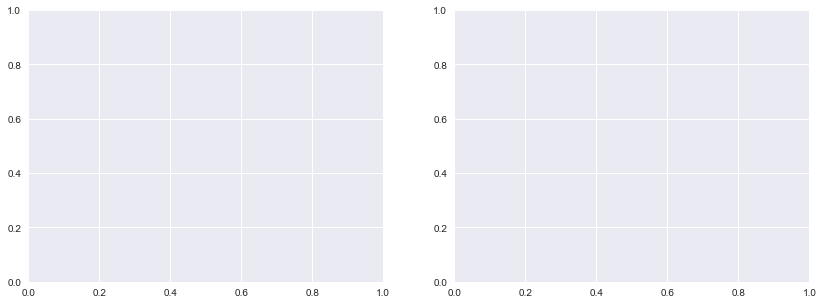

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(14,5))

pred_price = df_regression['endPrice_pred'].values
actual_price = df_regression['endPrice'].values

ax1.scatter(actual_price, pred_price)
ax1.set_title('Actual vs Predicted Price')

ax2.hist(actual_price, bins=30);
ax2.set_title('Distribution of Actual End Prices')

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(x=df_regression['endPrice_pred'].values-df_regression['endPrice'].values, bins=100);
plt.xlim((-75,75))
plt.ylim((0,500))
plt.ylabel('Predicted Price - Actual Price ($)')

In [ ]:
print 'average endPrice of listings: ${}'.format(round(np.mean(df_regression['endPrice']), 2))

### Explore relationship between startPrice, endPrice, and probability of sold_state==1

Plot startPrice vs. endPrice (where sold_state == 1), and startPrice vs. probability sold_state==1 on the same figure

In [119]:
# Select an item index to view start price vs. probability of sold 
item_index = 4002

In [161]:
auctions.ix[possible_indeces[item_index],:].loc['viewItemURL']

'http://www.ebay.com/itm/Canon-EOS-Rebel-T1i-EOS-500D-15-1MP-Digital-SLR-Camera-Black-Lens-/172560655691'

In [120]:
possible_indeces = list(df_classification[df_classification['sold_state']==1].index)
test_item_index = possible_indeces[item_index]

test_item_class = df_classification.ix[test_item_index, :]
test_item_reg = df_regression.ix[test_item_index, :]

In [121]:
testStartPrice = test_item_class.loc['startPrice']
testEndPrice = test_item_reg.loc['endPrice']

In [122]:
minStartPrice = 0
maxStartPrice = testStartPrice * 2
priceStepSize = 10

sold_probabilities = []
predicted_end_prices = []
    
max_expected_price = (0,0,0,0,0)
for i,price in enumerate(np.arange(minStartPrice, maxStartPrice, priceStepSize)):
    # Classification
    test_item_class.loc['startPrice'] = price
    test_vec = test_item_class.iloc[:-1].values.reshape(1,-1)
    sold_proba = rfc.predict_proba(test_vec)[0][1]
    sold_probabilities.append( (price, sold_proba) )
        
    # Regression
    test_item_reg.loc['startPrice'] = price
    test_vec = test_item_reg.iloc[:-1].values.reshape(1,-1)
    predicted_end_price = knn.predict(test_vec)[0]
    predicted_end_prices.append( (price, predicted_end_price) )
    
    
    # Find Optimal End Price
    if sold_proba > 0.5:
        expected_price = sold_probabilities[i][1] * predicted_end_prices[i][1] # Sold Probability * Predicted End Price
        if expected_price > max_expected_price[len(max_expected_price)-1]:
            max_expected_price = (i,price, sold_probabilities[i][1], predicted_end_prices[i][1], expected_price)
    
test_item_class_df = pd.DataFrame(sold_probabilities)
test_item_reg_df = pd.DataFrame(predicted_end_prices)

In [123]:
print 'Optimal Predicted End Price:${}, Optimal Start Price:${}, Chance of Selling:{}, Expected Profit:${}'.format(max_expected_price[3],
                                                                                                        max_expected_price[1],
                                                                                                        max_expected_price[2],
                                                                                                        max_expected_price[4])

Optimal Predicted End Price:$783.928578354, Optimal Start Price:$200.0, Chance of Selling:0.945666666667, Expected Profit:$741.335125597


Plot

In [245]:
plt.rcParams.update({'font.size': 16})

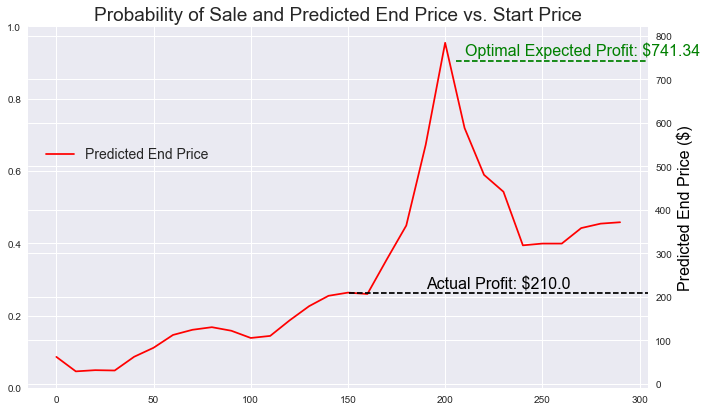

In [270]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Probability of sale
# ax1.plot(test_item_class_df[0], test_item_class_df[1], color='b', label='Probability of Selling')
# ax1.set_xlabel('Start Price ($)', fontsize=17)
# ax1.set_ylabel('Probability Of Selling (%)', color='k', fontsize=16)

# Predicted end Price
ax2 = ax1.twinx()
ax2.plot(test_item_reg_df[0], test_item_reg_df[1], color='r', label='Predicted End Price')
ax2.set_ylabel('Predicted End Price ($)', color='k',fontsize=16)

ax1.legend(bbox_to_anchor=(0.3, .74), loc=1, borderaxespad=0., fontsize=14)
ax2.legend(bbox_to_anchor=(0.3, .68), loc=1, borderaxespad=0., fontsize=14)

# # Optimal Predicted End Price Price
# plt.axvline(x=max_expected_price[1], ymin=0,linestyle='--', color='g') # optimal start price
plt.axhline(y=max_expected_price[4], xmin=max_expected_price[1]/np.max(test_item_class_df[0]), xmax=1, linestyle='--', color='g') # corresponding predicted end price
plt.text(np.max(test_item_class_df[0])-80,max_expected_price[4]+15,'Optimal Expected Profit: ${}'.format(round(max_expected_price[4],2)),color='g',rotation=0)

# # Actual startPrice / endPrice
# plt.axvline(x=testStartPrice, ymin=0, ymax=0.26,linestyle='--', color='k')
plt.axhline(y=testEndPrice, xmin=testStartPrice/np.max(test_item_class_df[0]), xmax=1, linestyle='--', color='k')
plt.text(np.max(test_item_class_df[0]-100),testEndPrice+10,'Actual Profit: ${}'.format(round(testEndPrice,2)),color='k',rotation=0)

plt.title('Probability of Sale and Predicted End Price vs. Start Price',fontsize=19)
fig.tight_layout()
plt.savefig('./Image/Profitability 7.jpeg')
plt.show()

Test for Canon 40D

## Explore Errors